| Features                             |
| ------------------------------------ |
| precipitacao                         |
| umidade_relativa_max                 |
| umidade_relativa_min                 |
| umidade_especifica                   |
| radiacao_solar                       |
| temperatura_min                      |
| temperatura_max                      |
| velocidade_vento                     |
| indice_queima                        |
| umidade_combustivel_morto_100_horas  |
| umidade_combustivel_morto_1000_horas |
| componente_energia_lancada           |
| evapotranspiracao_real               |
| evapotranspiracao_potencial          |
| deficit_pressao_vapor                |
| fire_id                              |
| latitude                             |
| longitude                            |
| data                                 |

<br>
<b>Umidade do combustível morto</b>: quantidade de água na matéria vegetal morta
<br>
<b>Componente de energia lançada</b>: índice que mede o potencial de liberação de calor

## Etapas

1. Remoção de linhas inconsistentes
2. Renomeação de colunas
3. Tratando erro nas datas
4. Separação de incêndios
5. Redução do dataset

In [9]:
# @title Importação de bibliotecas

import pandas as pd
import numpy as np
import requests, os
from pathlib import Path
import matplotlib.pyplot as plt
# from google.colab import files

In [10]:
# @title Carregamento do dataset

# Versão Collab
permalink = "https://github.com/mfigueireddo/ciencia-de-dados/blob/5a5657b346180db5a49e89bf900d811b53f9c3e3/datasets/raw_wildfires.parquet"
raw_url = permalink.replace("/blob/", "/raw/")

dest = Path("/content/raw_wildfires.parquet")

with requests.get(raw_url, stream=True) as r:
    r.raise_for_status()
    with open(dest, "wb") as f:
        for chunk in r.iter_content(chunk_size=1024 * 1024):
            if chunk:
                f.write(chunk)

# Leitura do arquivo .csv
wildfires = pd.read_parquet(dest, engine="pyarrow")

# Versão VSCode
# file_path = "../datasets/raw_wildfires.parquet"

# wildfires = pd.read_parquet(
#     file_path,
#     engine="pyarrow",
#     use_nullable_dtypes=False
# )

In [11]:
# @title 1. Remoção de dados inconsistentes

wildfires = wildfires.drop(wildfires.index[-1])
wildfires = wildfires[wildfires['sph'] != 32767].reset_index(drop=True)

In [14]:
# @title 2. Renomeação de colunas

rename_dict = {
    'latitude': 'latitude',
    'longitude': 'longitude',
    'datetime': 'data',
    'Wildfire': 'houve_incendio',
    'pr': 'precipitacao',
    'rmax': 'umidade_relativa_max',
    'rmin': 'umidade_relativa_min',
    'sph': 'umidade_especifica',
    'srad': 'radiacao_solar',
    'tmmn': 'temperatura_min',
    'tmmx': 'temperatura_max',
    'vs': 'velocidade_vento',
    'bi': 'indice_queima',
    'fm100': 'umidade_combustivel_morto_100_horas',
    'fm1000': 'umidade_combustivel_morto_1000_horas',
    'erc': 'componente_energia_lancada',
    'etr': 'evapotranspiracao_real',
    'pet': 'evapotranspiracao_potencial',
    'vpd': 'deficit_pressao_vapor'
}

# Renomear colunas
wildfires = wildfires.rename(columns=rename_dict)

In [15]:
# @title 3. Tratamento de erro nas datas

wildfires['data'] = pd.to_datetime(wildfires['data'], errors='coerce', utc=False)

# Ordenação por célula e data
DECIMALS = 2
wildfires['lat_cell'] = wildfires['latitude'].round(DECIMALS)
wildfires['lon_cell'] = wildfires['longitude'].round(DECIMALS)
wildfires = wildfires.sort_values(['lat_cell','lon_cell','data']).reset_index(drop=True)

# Recomputar prev_data e gap (apenas para validar que a subtração agora funciona)
wildfires['prev_data'] = wildfires.groupby(['lat_cell','lon_cell'])['data'].shift()
gap_td = wildfires['data'] - wildfires['prev_data']
wildfires['gap_dias'] = gap_td.dt.days

/tmp/ipython-input-2140966150.py:29: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly = df.resample('M', on='data')['fire_occurred'].sum()
/tmp/ipython-input-2140966150.py:43: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  .resample('M', on='data')['fire_occurred']
/tmp/ipython-input-2140966150.py:77: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[1].boxplot(monthly_data,


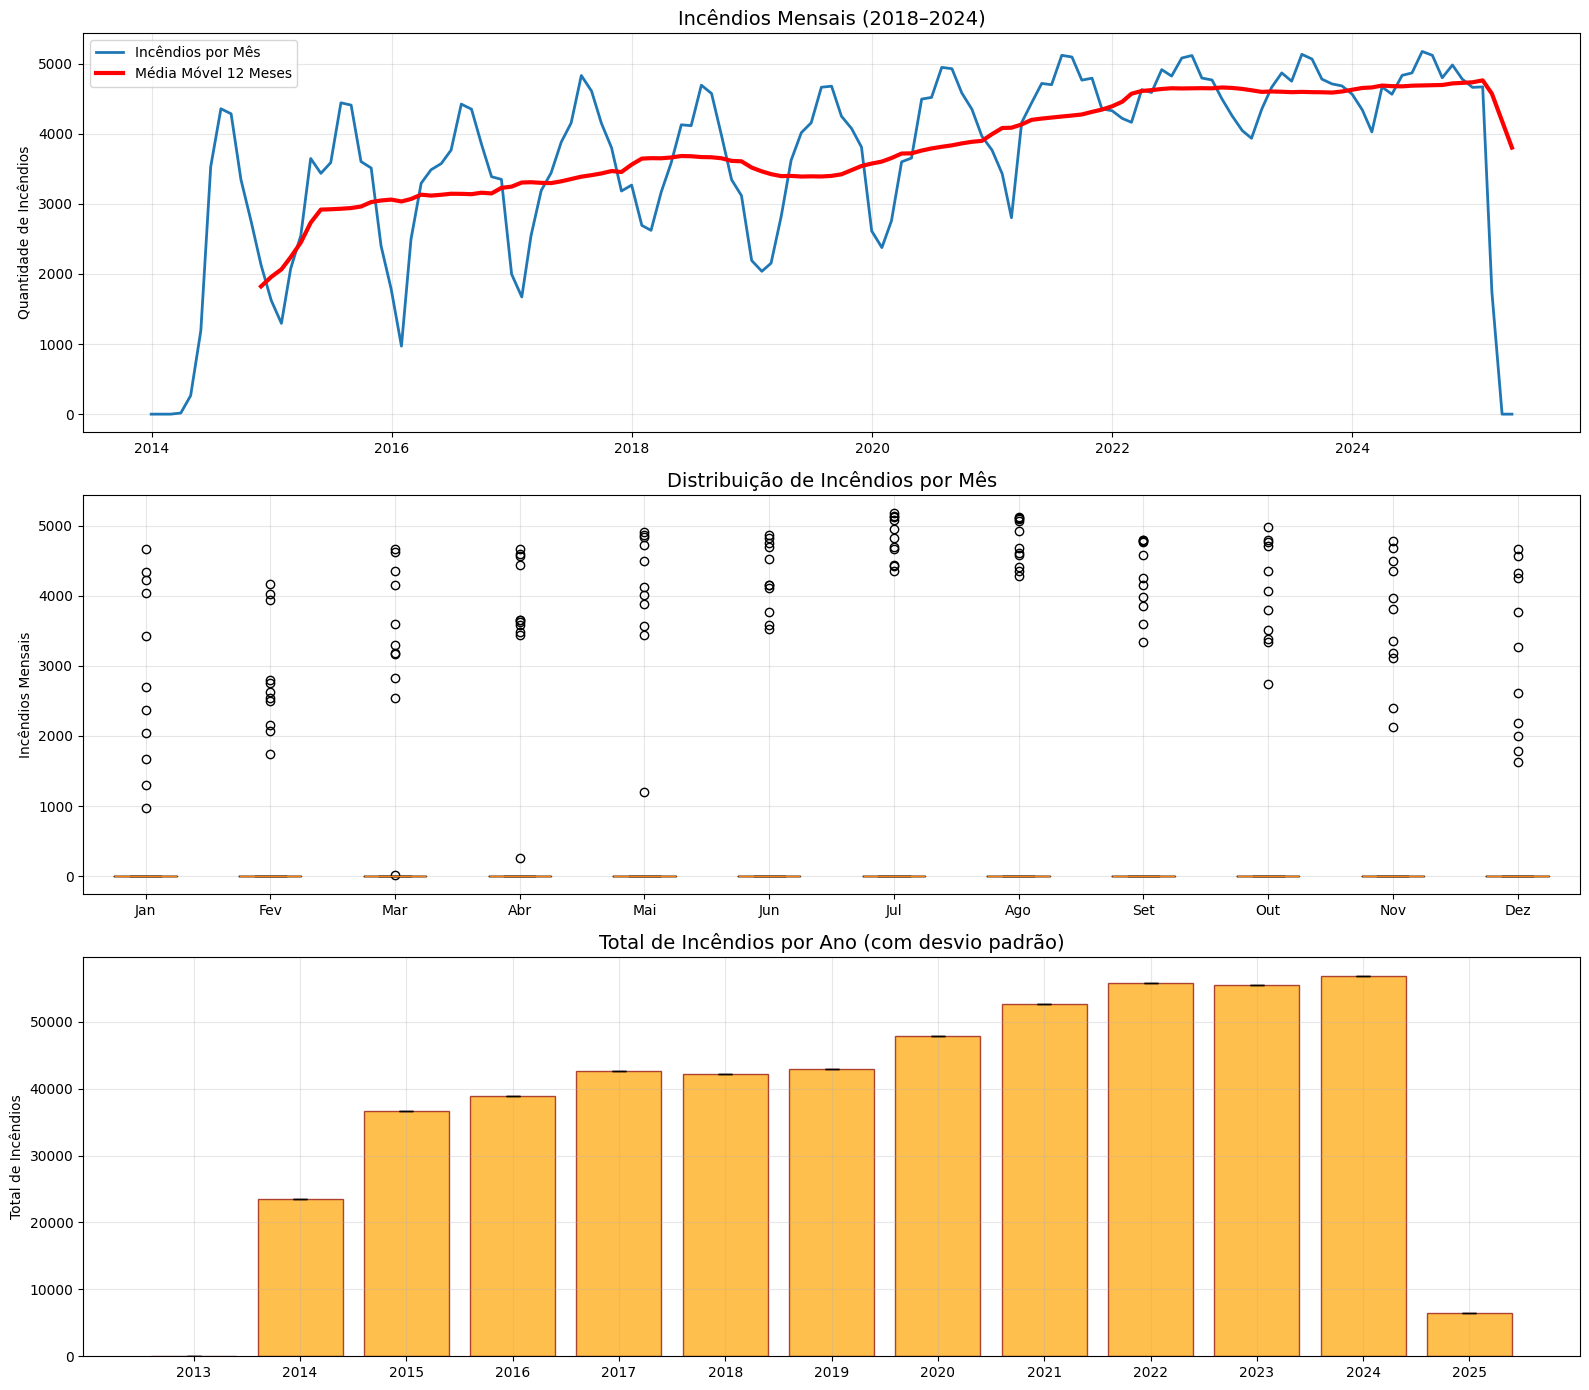

In [18]:
# @title Análise séries temporais

df = wildfires.copy()

# Converter Yes/No para binário
df['fire_occurred'] = df['houve_incendio'].map({'Yes': 1, 'No': 0})

# Garantir colunas de ano e mês
df['year'] = df['data'].dt.year
df['month'] = df['data'].dt.month

# Total de incêndios por mês
monthly = df.resample('M', on='data')['fire_occurred'].sum()

# Média móvel de 12 meses
monthly_MA12 = monthly.rolling(window=12).mean()

# Boxplot por mês

monthly_data = []

for m in range(1, 13):
    valores_mes = (
        df[df['month'] == m]
        .resample('M', on='data')['fire_occurred']
        .sum()
        .values
    )
    monthly_data.append(valores_mes)

# Agregação por ano (total, média, desvio padrão)

yearly = df.groupby('year')['fire_occurred'].agg(['sum', 'mean', 'std'])
x_pos = np.arange(len(yearly))

fig, axes = plt.subplots(3, 1, figsize=(16, 14))

# Série temporal

axes[0].plot(monthly.index, monthly.values,
             linewidth=2, label='Incêndios por Mês')

axes[0].plot(monthly_MA12.index, monthly_MA12.values,
             linewidth=3, color='red', label='Média Móvel 12 Meses')

axes[0].set_title('Incêndios Mensais (2018–2024)', fontsize=14)
axes[0].set_ylabel('Quantidade de Incêndios')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Boxplot mensal

axes[1].boxplot(monthly_data,
                labels=['Jan', 'Fev', 'Mar', 'Abr', 'Mai', 'Jun',
                        'Jul', 'Ago', 'Set', 'Out', 'Nov', 'Dez'])

axes[1].set_title('Distribuição de Incêndios por Mês', fontsize=14)
axes[1].set_ylabel('Incêndios Mensais')
axes[1].grid(alpha=0.3)

# Barras por ano

axes[2].bar(x_pos, yearly['sum'], yerr=yearly['std'],
            capsize=5, color='orange', edgecolor='darkred', alpha=0.7)

axes[2].set_xticks(x_pos)
axes[2].set_xticklabels(yearly.index)
axes[2].set_title('Total de Incêndios por Ano (com desvio padrão)', fontsize=14)
axes[2].set_ylabel('Total de Incêndios')
axes[2].grid(alpha=0.3)

plt.tight_layout()
plt.show()


In [6]:
# @title 4. Separação de incêndios

MAX_GAP_DIAS = 20

# Converter NaN das primeiras linhas em "lacuna grande" para sinalizar novo evento
wildfires.loc[wildfires['gap_dias'].isna(), 'gap_dias'] = MAX_GAP_DIAS + 1

# Flag de novo evento por célula
wildfires['novo_evento'] = (wildfires['gap_dias'] > MAX_GAP_DIAS).astype('int8')

# Sequência por célula
wildfires['fire_seq'] = (
    wildfires
    .groupby(['lat_cell','lon_cell'])['novo_evento']
    .cumsum()
)

# Identificador global
wildfires['fire_id'] = (
    wildfires['lat_cell'].astype(str) + '_' +
    wildfires['lon_cell'].astype(str) + '_' +
    wildfires['fire_seq'].astype(str)
)

In [7]:
# @title 5. Redução do dataset

# Recorte 2024

# Robustez para 'houve_incendio'
if wildfires['houve_incendio'].dtype != 'bool':
    wildfires['houve_incendio'] = (
        wildfires['houve_incendio']
        .astype(str).str.strip().str.lower()
        .map({'true': True, 'false': False, 'yes': True, 'no': False, '1': True, '0': False})
        .fillna(False)
        .astype(bool)
    )

# Âncora por fire_id
primeiro_true = (
    wildfires[wildfires['houve_incendio']]
    .groupby('fire_id', as_index=False)['data'].min()
    .rename(columns={'data': 'data_inicio_fogo'})
)

min_grupo = (
    wildfires.groupby('fire_id', as_index=False)['data']
    .min()
    .rename(columns={'data': 'data_min_grupo'})
)
ancoras = min_grupo.merge(primeiro_true, on='fire_id', how='left')
ancoras['data_ancora'] = ancoras['data_inicio_fogo'].fillna(ancoras['data_min_grupo'])
ancoras = ancoras[['fire_id', 'data_ancora']]

# Recorte por período
ANO_INICIO, ANO_FIM = 2024, 2024
inicio = pd.Timestamp(f'{ANO_INICIO}-01-01')
fim    = pd.Timestamp(f'{ANO_FIM}-12-31')

ids_periodo = ancoras.loc[
    (ancoras['data_ancora'] >= inicio) & (ancoras['data_ancora'] <= fim),
    'fire_id'
]

wildfires_reduzido = wildfires[wildfires['fire_id'].isin(ids_periodo)].copy()

In [8]:
# @title Salvamento do dataset

# Manter apenas colunas de interesse
cols_aux = {'prev_data','gap_dias','novo_evento','fire_seq','lat_cell','lon_cell'}
cols_keep = [c for c in wildfires_reduzido.columns if c not in cols_aux]
wildfires_reduzido = wildfires_reduzido[cols_keep].copy()

# Ordenação
ordem = [c for c in ['data','latitude','longitude','houve_incendio','fire_id'] if c in wildfires_reduzido.columns]
ordem += [c for c in wildfires_reduzido.columns if c not in ordem]
wildfires_reduzido = wildfires_reduzido[ordem]

# Se tiver categóricas, transformar para string antes do CSV evita "category codes" indevidos
for c in wildfires_reduzido.select_dtypes(['category']).columns:
    wildfires_reduzido[c] = wildfires_reduzido[c].astype('string')

# Versão Collab
caminho_saida = Path("/content/pre-pipeline_wildfires.parquet")

# Versão VSCode
# caminho_saida = "../datasets/pre-pipeline_wildfires.parquet"

# Garantir ISO
wildfires_reduzido['data'] = pd.to_datetime(wildfires_reduzido['data']).dt.strftime('%Y-%m-%d')

wildfires_reduzido.to_parquet(
    caminho_saida,
    engine="pyarrow",
    compression="zstd",
    index=False
)

# Versão Collab
# files.download(str(caminho_saida))